# Traffic Stop Activity Result: Citation vs. Warning 

#### BA 590 Capstone: Business Analytics Applications - Proposal
#### Proposed By: Kendall Stopa
1.	Project Background/Motivation
    - Millions of Americans are stopped each year due to traffic violations. There are many reasons as to why one would be pulled over such as speeding, using a cellphone, not wearing a seatbelt, etc. What I want to know is what dictates the end result of a traffic stop? 

2.	Problem Statement/Statement of Work
    - What features are most strongly associated with an activity result of a citation or a warning?  

3.	 Preliminary Results/Exploratory Data Analysis (see figures on page 2-3)
    - The dataset that I will be using is information available in the Louisville Metro Police Department Vehicle Stops Database for 2015 – 2018, obtained from Data.gov. There are 111,582 rows and 18 columns in this dataset. 

4.	Planning Timeline with Milestones (start and end dates) for each phase of the project
    - EDA and Preprocessing &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Start: 5/18 – End: 5/21
    - Modeling &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Start: 5/22 – End: 6/01
    - Geo coding &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Start: 6/03 – End: 6/15
    - Concluding Project &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Start: 6/17 – End: 6/23

5.	Summary of expected results
    - The expected result of this analytical project is to build multiple classification models commonly used machine learning algorithms to predict the activity result one would receive during a traffic stop and determine the most accurate predictive model to use for this data. To see which features of a traffic stop have the largest impact on predicting the activity result of a traffic stop I will be using feature selection. I will also be geocoding the location of each traffic stop to explore this data spatially and create a visualization where the activity result was given. 


6.	 Signoff from your advisor and your subject matter expert: 
    - Dr. Christopher Huntly
    - Mike Garvey (Alumni Class of ’89, 20 years Rockland County Police Department)




In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
#importing packages we know we will need upfront
import seaborn as sns

from scipy.stats import iqr

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [3]:
# Uploading imputed data to df from CSV WorkingDataFrame
df = pd.read_csv('BA590-LMPD/LMPDStopsDatFrame.csv', index_col=0)
df.head()

,ID,TYPE_OF_STOP,CITATION_CONTROL_NUMBER,ACTIVITY RESULTS,OFFICER_GENDER,OFFICER_RACE,OFFICER_AGE_RANGE,ACTIVITY_DATE,ACTIVITY_TIME,ACTIVITY_LOCATION,ACTIVITY_DIVISION,ACTIVITY_BEAT,DRIVER_GENDER,DRIVER_RACE,DRIVER_AGE_RANGE,NUMBER OF PASSENGERS,WAS_VEHCILE_SEARCHED,REASON_FOR_SEARCH
0,1,NaN,NaN,WARNING,NaN,NaN,NaN,2015-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,2,NaN,NaN,WARNING,NaN,NaN,NaN,2015-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,3,NaN,NaN,WARNING,NaN,NaN,NaN,2016-09-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
3,4,NaN,NaN,WARNING,F,WHITE,21 - 30,2016-01-22,14:42:00,SHAWNEE PARK,2ND DIVISION,BEAT 1,M,BLACK,31 - 40,3,NO,NaN
4,5,NaN,NaN,WARNING,F,WHITE,21 - 30,2015-09-14,21:10:00,RIVERPARK/34TH,2ND DIVISION,BEAT 1,M,BLACK,20 - 25,0,YES,PROBABLE CAUSE


# EDA #

In [4]:
df.shape

(111582, 18)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111582 entries, 0 to 111581
Data columns (total 18 columns):
ID                         111582 non-null int64
TYPE_OF_STOP               111455 non-null object
CITATION_CONTROL_NUMBER    94158 non-null object
ACTIVITY RESULTS           111582 non-null object
OFFICER_GENDER             111426 non-null object
OFFICER_RACE               111426 non-null object
OFFICER_AGE_RANGE          109086 non-null object
ACTIVITY_DATE              111582 non-null object
ACTIVITY_TIME              111548 non-null object
ACTIVITY_LOCATION          111443 non-null object
ACTIVITY_DIVISION          111189 non-null object
ACTIVITY_BEAT              111163 non-null object
DRIVER_GENDER              111546 non-null object
DRIVER_RACE                111550 non-null object
DRIVER_AGE_RANGE           111554 non-null object
NUMBER OF PASSENGERS       111582 non-null int64
WAS_VEHCILE_SEARCHED       111579 non-null object
REASON_FOR_SEARCH          6922 non-null o

In [6]:
df.isnull().sum()

ID                              0
TYPE_OF_STOP                  127
CITATION_CONTROL_NUMBER     17424
ACTIVITY RESULTS                0
OFFICER_GENDER                156
OFFICER_RACE                  156
OFFICER_AGE_RANGE            2496
ACTIVITY_DATE                   0
ACTIVITY_TIME                  34
ACTIVITY_LOCATION             139
ACTIVITY_DIVISION             393
ACTIVITY_BEAT                 419
DRIVER_GENDER                  36
DRIVER_RACE                    32
DRIVER_AGE_RANGE               28
NUMBER OF PASSENGERS            0
WAS_VEHCILE_SEARCHED            3
REASON_FOR_SEARCH          104660
dtype: int64

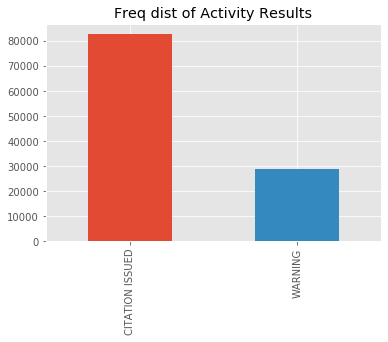

In [8]:
df['ACTIVITY RESULTS'].value_counts().plot.bar(title="Freq dist of Activity Results")

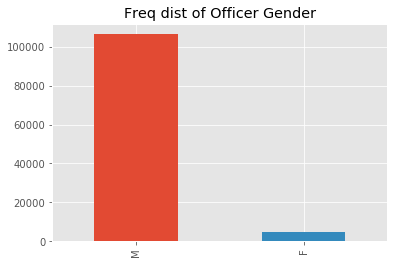

In [9]:
df['OFFICER_GENDER'].value_counts().plot.bar(title="Freq dist of Officer Gender")

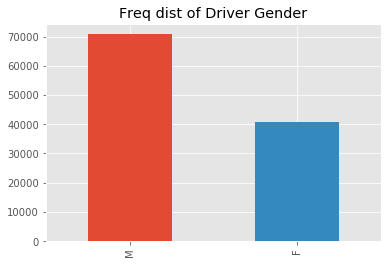

In [10]:
df['DRIVER_GENDER'].value_counts().plot.bar(title="Freq dist of Driver Gender")

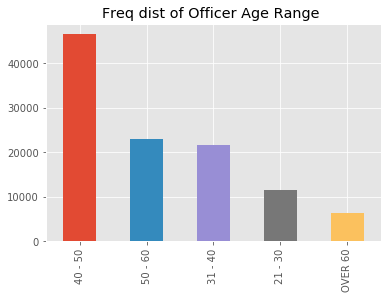

In [11]:
df['OFFICER_AGE_RANGE'].value_counts().plot.bar(title="Freq dist of Officer Age Range ")

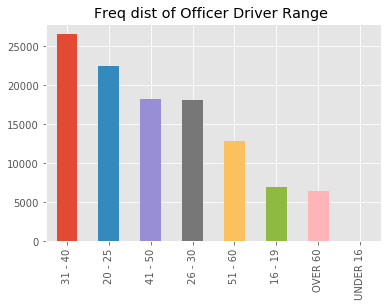

In [12]:
df['DRIVER_AGE_RANGE'].value_counts().plot.bar(title="Freq dist of Officer Driver Range ")

Text(0.5, 1.0, 'Officer Age versus Activity Result')

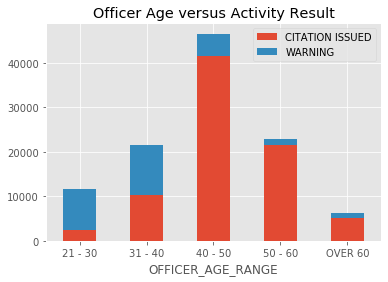

In [13]:
test7 = df.groupby(['OFFICER_AGE_RANGE', 'ACTIVITY RESULTS'])['DRIVER_AGE_RANGE'].count().unstack('ACTIVITY RESULTS').fillna(0)
test7.plot(kind='bar', stacked=True)
plt.xticks(rotation='horizontal')
plt.legend()
plt.title('Officer Age versus Activity Result')

Text(0.5, 1.0, 'Driver Age versus Activity Result')

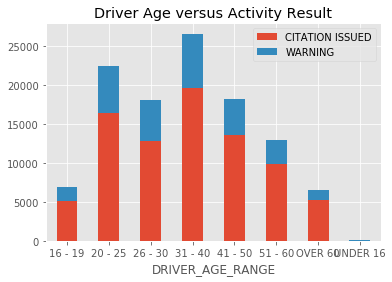

In [14]:
test7 = df.groupby(['DRIVER_AGE_RANGE', 'ACTIVITY RESULTS'])['DRIVER_AGE_RANGE'].count().unstack('ACTIVITY RESULTS').fillna(0)
test7.plot(kind='bar', stacked=True)
plt.xticks(rotation='horizontal')
plt.legend()
plt.title('Driver Age versus Activity Result')

Text(0.5, 1.0, 'Odor versus Class')

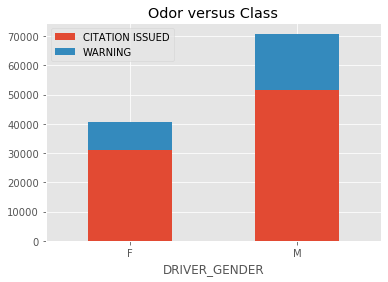

In [15]:
test7 = df.groupby(['DRIVER_GENDER', 'ACTIVITY RESULTS'])['DRIVER_GENDER'].count().unstack('ACTIVITY RESULTS').fillna(0)
test7.plot(kind='bar', stacked=True)
plt.xticks(rotation='horizontal')
plt.legend()
plt.title('Odor versus Class')

# Data Imputation & Cleaning #

In [17]:
#fill missing values for each column using its own most frequent value
df = df.fillna(df.mode().iloc[0])
df.isnull().sum()

ID                         0
TYPE_OF_STOP               0
CITATION_CONTROL_NUMBER    0
ACTIVITY RESULTS           0
OFFICER_GENDER             0
OFFICER_RACE               0
OFFICER_AGE_RANGE          0
ACTIVITY_DATE              0
ACTIVITY_TIME              0
ACTIVITY_LOCATION          0
ACTIVITY_DIVISION          0
ACTIVITY_BEAT              0
DRIVER_GENDER              0
DRIVER_RACE                0
DRIVER_AGE_RANGE           0
NUMBER OF PASSENGERS       0
WAS_VEHCILE_SEARCHED       0
REASON_FOR_SEARCH          0
dtype: int64

In [18]:
# Creating a copy of the dataset, to recode values to be numerical for data analysis. 
df2 = df.copy(deep=True)
df2.head()

,ID,TYPE_OF_STOP,CITATION_CONTROL_NUMBER,ACTIVITY RESULTS,OFFICER_GENDER,OFFICER_RACE,OFFICER_AGE_RANGE,ACTIVITY_DATE,ACTIVITY_TIME,ACTIVITY_LOCATION,ACTIVITY_DIVISION,ACTIVITY_BEAT,DRIVER_GENDER,DRIVER_RACE,DRIVER_AGE_RANGE,NUMBER OF PASSENGERS,WAS_VEHCILE_SEARCHED,REASON_FOR_SEARCH
0,1,TRAFFIC VIOLATION,0,WARNING,M,WHITE,40 - 50,2015-01-24,22:00:00,DIXIE HWY ...,6TH DIVISION,BEAT 2,M,WHITE,31 - 40,0,NO,CONSENT
1,2,TRAFFIC VIOLATION,0,WARNING,M,WHITE,40 - 50,2015-01-30,22:00:00,DIXIE HWY ...,6TH DIVISION,BEAT 2,M,WHITE,31 - 40,0,NO,CONSENT
2,3,TRAFFIC VIOLATION,0,WARNING,M,WHITE,40 - 50,2016-09-20,22:00:00,DIXIE HWY ...,6TH DIVISION,BEAT 2,M,WHITE,31 - 40,0,NO,CONSENT
3,4,TRAFFIC VIOLATION,0,WARNING,F,WHITE,21 - 30,2016-01-22,14:42:00,SHAWNEE PARK,2ND DIVISION,BEAT 1,M,BLACK,31 - 40,3,NO,CONSENT
4,5,TRAFFIC VIOLATION,0,WARNING,F,WHITE,21 - 30,2015-09-14,21:10:00,RIVERPARK/34TH,2ND DIVISION,BEAT 1,M,BLACK,20 - 25,0,YES,PROBABLE CAUSE


In [19]:
print(df2.nunique())

ID                         111582
TYPE_OF_STOP                    3
CITATION_CONTROL_NUMBER     82661
ACTIVITY RESULTS                2
OFFICER_GENDER                  2
OFFICER_RACE                    5
OFFICER_AGE_RANGE               5
ACTIVITY_DATE                1125
ACTIVITY_TIME                1440
ACTIVITY_LOCATION           47718
ACTIVITY_DIVISION              10
ACTIVITY_BEAT                   8
DRIVER_GENDER                   2
DRIVER_RACE                    10
DRIVER_AGE_RANGE                8
NUMBER OF PASSENGERS           26
WAS_VEHCILE_SEARCHED            2
REASON_FOR_SEARCH             296
dtype: int64


In [20]:
X1 = df2.filter(['TYPE_OF_STOP', 'OFFICER_GENDER', 'DRIVER_GENDER',
       'WAS_VEHCILE_SEARCHED'])
X2 = df2.filter(['ID', 'CITATION_CONTROL_NUMBER', 'ACTIVITY_DATE', 'ACTIVITY_TIME', 'ACTIVITY_LOCATION', 
        'ACTIVITY_DIVISION', 'ACTIVITY_BEAT', 'OFFICER_AGE_RANGE', 'DRIVER_AGE_RANGE', 'REASON_FOR_SEARCH'])
y = df2.iloc[:, 3]


In [21]:
y1 = pd.get_dummies(y)
y1.head()

,CITATION ISSUED,WARNING
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [22]:
X1 = pd.get_dummies(X1)
X1.head()

,TYPE_OF_STOP_COMPLAINT/CRIMINAL VIOLATION,TYPE_OF_STOP_COMPLIANCE STOP (KVE ONLY),TYPE_OF_STOP_TRAFFIC VIOLATION,OFFICER_GENDER_F,OFFICER_GENDER_M,DRIVER_GENDER_F,DRIVER_GENDER_M,WAS_VEHCILE_SEARCHED_NO,WAS_VEHCILE_SEARCHED_YES
0,0,0,1,0,1,0,1,1,0
1,0,0,1,0,1,0,1,1,0
2,0,0,1,0,1,0,1,1,0
3,0,0,1,1,0,0,1,1,0
4,0,0,1,1,0,0,1,0,1


In [23]:
df_concat = pd.concat([X1, X2], axis=1, sort=False)
df_concat.head()

,TYPE_OF_STOP_COMPLAINT/CRIMINAL VIOLATION,TYPE_OF_STOP_COMPLIANCE STOP (KVE ONLY),TYPE_OF_STOP_TRAFFIC VIOLATION,OFFICER_GENDER_F,OFFICER_GENDER_M,DRIVER_GENDER_F,DRIVER_GENDER_M,WAS_VEHCILE_SEARCHED_NO,WAS_VEHCILE_SEARCHED_YES,ID,CITATION_CONTROL_NUMBER,ACTIVITY_DATE,ACTIVITY_TIME,ACTIVITY_LOCATION,ACTIVITY_DIVISION,ACTIVITY_BEAT,OFFICER_AGE_RANGE,DRIVER_AGE_RANGE,REASON_FOR_SEARCH
0,0,0,1,0,1,0,1,1,0,1,0,2015-01-24,22:00:00,DIXIE HWY ...,6TH DIVISION,BEAT 2,40 - 50,31 - 40,CONSENT
1,0,0,1,0,1,0,1,1,0,2,0,2015-01-30,22:00:00,DIXIE HWY ...,6TH DIVISION,BEAT 2,40 - 50,31 - 40,CONSENT
2,0,0,1,0,1,0,1,1,0,3,0,2016-09-20,22:00:00,DIXIE HWY ...,6TH DIVISION,BEAT 2,40 - 50,31 - 40,CONSENT
3,0,0,1,1,0,0,1,1,0,4,0,2016-01-22,14:42:00,SHAWNEE PARK,2ND DIVISION,BEAT 1,21 - 30,31 - 40,CONSENT
4,0,0,1,1,0,0,1,0,1,5,0,2015-09-14,21:10:00,RIVERPARK/34TH,2ND DIVISION,BEAT 1,21 - 30,20 - 25,PROBABLE CAUSE


In [24]:
#replacing year with 2025 to 2015.. assuming a typo 
df_concat['ACTIVITY_DATE'] = df_concat['ACTIVITY_DATE'].str.replace("2025","2015")

In [25]:
#converting time column data type to Datetime64
df_concat['ACTIVITY_DATE']=df_concat['ACTIVITY_DATE'].astype('Datetime64',copy=True) 

In [26]:
#Adding new column of just the year of the activity date
df_concat['ACTIVITY_MONTH_YEAR'] = df_concat['ACTIVITY_DATE'].dt.strftime('%m/%y')
df_concat['ACTIVITY_MONTH'] = df_concat['ACTIVITY_DATE'].dt.strftime('%m')
df_concat['ACTIVITY_DAY'] = df_concat['ACTIVITY_DATE'].dt.strftime('%d') 
df_concat['ACTIVITY_YEAR'] = df_concat['ACTIVITY_DATE'].dt.strftime('%y')
df_concat.head()

,TYPE_OF_STOP_COMPLAINT/CRIMINAL VIOLATION,TYPE_OF_STOP_COMPLIANCE STOP (KVE ONLY),TYPE_OF_STOP_TRAFFIC VIOLATION,OFFICER_GENDER_F,OFFICER_GENDER_M,DRIVER_GENDER_F,DRIVER_GENDER_M,WAS_VEHCILE_SEARCHED_NO,WAS_VEHCILE_SEARCHED_YES,ID,...,ACTIVITY_LOCATION,ACTIVITY_DIVISION,ACTIVITY_BEAT,OFFICER_AGE_RANGE,DRIVER_AGE_RANGE,REASON_FOR_SEARCH,ACTIVITY_MONTH_YEAR,ACTIVITY_MONTH,ACTIVITY_DAY,ACTIVITY_YEAR
0,0,0,1,0,1,0,1,1,0,1,...,DIXIE HWY ...,6TH DIVISION,BEAT 2,40 - 50,31 - 40,CONSENT,01/15,01,24,15
1,0,0,1,0,1,0,1,1,0,2,...,DIXIE HWY ...,6TH DIVISION,BEAT 2,40 - 50,31 - 40,CONSENT,01/15,01,30,15
2,0,0,1,0,1,0,1,1,0,3,...,DIXIE HWY ...,6TH DIVISION,BEAT 2,40 - 50,31 - 40,CONSENT,09/16,09,20,16
3,0,0,1,1,0,0,1,1,0,4,...,SHAWNEE PARK,2ND DIVISION,BEAT 1,21 - 30,31 - 40,CONSENT,01/16,01,22,16
4,0,0,1,1,0,0,1,0,1,5,...,RIVERPARK/34TH,2ND DIVISION,BEAT 1,21 - 30,20 - 25,PROBABLE CAUSE,09/15,09,14,15


In [27]:
df_concat['ACTIVITY_YEAR'].unique()

array(['15', '16', '17', '18'], dtype=object)

In [28]:
df_concat['ACTIVITY_DIVISION'].unique()

array(['6TH DIVISION', '2ND DIVISION', '3RD DIVISION', '5TH DIVISION',
       '4TH DIVISION', '7TH DIVISION', '8TH DIVISION', '1ST DIVISION',
       'NON LMPD', ' '], dtype=object)

In [29]:
#Adding new column of just the year of the activity date
df_concat['ACTIVITY_MONTH_YEAR'] = df_concat['ACTIVITY_DATE'].dt.strftime('%m/%y')
df_concat['ACTIVITY_MONTH'] = df_concat['ACTIVITY_DATE'].dt.strftime('%m')
df_concat['ACTIVITY_DAY'] = df_concat['ACTIVITY_DATE'].dt.strftime('%d') 
df_concat['ACTIVITY_YEAR'] = df_concat['ACTIVITY_DATE'].dt.strftime('%y')
df_concat.head()

,TYPE_OF_STOP_COMPLAINT/CRIMINAL VIOLATION,TYPE_OF_STOP_COMPLIANCE STOP (KVE ONLY),TYPE_OF_STOP_TRAFFIC VIOLATION,OFFICER_GENDER_F,OFFICER_GENDER_M,DRIVER_GENDER_F,DRIVER_GENDER_M,WAS_VEHCILE_SEARCHED_NO,WAS_VEHCILE_SEARCHED_YES,ID,...,ACTIVITY_LOCATION,ACTIVITY_DIVISION,ACTIVITY_BEAT,OFFICER_AGE_RANGE,DRIVER_AGE_RANGE,REASON_FOR_SEARCH,ACTIVITY_MONTH_YEAR,ACTIVITY_MONTH,ACTIVITY_DAY,ACTIVITY_YEAR
0,0,0,1,0,1,0,1,1,0,1,...,DIXIE HWY ...,6TH DIVISION,BEAT 2,40 - 50,31 - 40,CONSENT,01/15,01,24,15
1,0,0,1,0,1,0,1,1,0,2,...,DIXIE HWY ...,6TH DIVISION,BEAT 2,40 - 50,31 - 40,CONSENT,01/15,01,30,15
2,0,0,1,0,1,0,1,1,0,3,...,DIXIE HWY ...,6TH DIVISION,BEAT 2,40 - 50,31 - 40,CONSENT,09/16,09,20,16
3,0,0,1,1,0,0,1,1,0,4,...,SHAWNEE PARK,2ND DIVISION,BEAT 1,21 - 30,31 - 40,CONSENT,01/16,01,22,16
4,0,0,1,1,0,0,1,0,1,5,...,RIVERPARK/34TH,2ND DIVISION,BEAT 1,21 - 30,20 - 25,PROBABLE CAUSE,09/15,09,14,15


In [30]:
#Changing column Activity_Time from 24 hour to 12 hour 
import datetime
times = df_concat['ACTIVITY_TIME']
df_concat['ACTIVITY_TIME']=[datetime.datetime.strptime(time, "%H:%M:%S").strftime("%I:%M %p") for time in times]

In [31]:
#Replacing 'over 60' with age range 61-70, and 'UNDER 16' with age range 15-10
df_concat = df_concat.replace({'OFFICER_AGE_RANGE': {'OVER 60': '61 - 70'}})
df_concat = df_concat.replace({'DRIVER_AGE_RANGE': {'OVER 60': '61 - 70', 'UNDER 16': '15 - 10'}})
df_concat.head()

,TYPE_OF_STOP_COMPLAINT/CRIMINAL VIOLATION,TYPE_OF_STOP_COMPLIANCE STOP (KVE ONLY),TYPE_OF_STOP_TRAFFIC VIOLATION,OFFICER_GENDER_F,OFFICER_GENDER_M,DRIVER_GENDER_F,DRIVER_GENDER_M,WAS_VEHCILE_SEARCHED_NO,WAS_VEHCILE_SEARCHED_YES,ID,...,ACTIVITY_LOCATION,ACTIVITY_DIVISION,ACTIVITY_BEAT,OFFICER_AGE_RANGE,DRIVER_AGE_RANGE,REASON_FOR_SEARCH,ACTIVITY_MONTH_YEAR,ACTIVITY_MONTH,ACTIVITY_DAY,ACTIVITY_YEAR
0,0,0,1,0,1,0,1,1,0,1,...,DIXIE HWY ...,6TH DIVISION,BEAT 2,40 - 50,31 - 40,CONSENT,01/15,01,24,15
1,0,0,1,0,1,0,1,1,0,2,...,DIXIE HWY ...,6TH DIVISION,BEAT 2,40 - 50,31 - 40,CONSENT,01/15,01,30,15
2,0,0,1,0,1,0,1,1,0,3,...,DIXIE HWY ...,6TH DIVISION,BEAT 2,40 - 50,31 - 40,CONSENT,09/16,09,20,16
3,0,0,1,1,0,0,1,1,0,4,...,SHAWNEE PARK,2ND DIVISION,BEAT 1,21 - 30,31 - 40,CONSENT,01/16,01,22,16
4,0,0,1,1,0,0,1,0,1,5,...,RIVERPARK/34TH,2ND DIVISION,BEAT 1,21 - 30,20 - 25,PROBABLE CAUSE,09/15,09,14,15


In [32]:
#using split_mean() function to split age ranges to calculate mean, added columns'OFFICER_AGE_MEAN' & 'DRIVER_AGE_MEAN'
def split_mean(x):
    split_list = x.split('-')
    mean = (float(split_list[0])+float(split_list[1]))/2
    return mean

df_concat['OFFICER_AGE_MEAN'] = df_concat['OFFICER_AGE_RANGE'].apply(lambda x: split_mean(x))
df_concat['DRIVER_AGE_MEAN'] = df_concat['DRIVER_AGE_RANGE'].apply(lambda x: split_mean(x))

In [33]:
df_concat.head()

,TYPE_OF_STOP_COMPLAINT/CRIMINAL VIOLATION,TYPE_OF_STOP_COMPLIANCE STOP (KVE ONLY),TYPE_OF_STOP_TRAFFIC VIOLATION,OFFICER_GENDER_F,OFFICER_GENDER_M,DRIVER_GENDER_F,DRIVER_GENDER_M,WAS_VEHCILE_SEARCHED_NO,WAS_VEHCILE_SEARCHED_YES,ID,...,ACTIVITY_BEAT,OFFICER_AGE_RANGE,DRIVER_AGE_RANGE,REASON_FOR_SEARCH,ACTIVITY_MONTH_YEAR,ACTIVITY_MONTH,ACTIVITY_DAY,ACTIVITY_YEAR,OFFICER_AGE_MEAN,DRIVER_AGE_MEAN
0,0,0,1,0,1,0,1,1,0,1,...,BEAT 2,40 - 50,31 - 40,CONSENT,01/15,01,24,15,45.0,35.5
1,0,0,1,0,1,0,1,1,0,2,...,BEAT 2,40 - 50,31 - 40,CONSENT,01/15,01,30,15,45.0,35.5
2,0,0,1,0,1,0,1,1,0,3,...,BEAT 2,40 - 50,31 - 40,CONSENT,09/16,09,20,16,45.0,35.5
3,0,0,1,1,0,0,1,1,0,4,...,BEAT 1,21 - 30,31 - 40,CONSENT,01/16,01,22,16,25.5,35.5
4,0,0,1,1,0,0,1,0,1,5,...,BEAT 1,21 - 30,20 - 25,PROBABLE CAUSE,09/15,09,14,15,25.5,22.5


<Figure size 8000x4800 with 0 Axes>

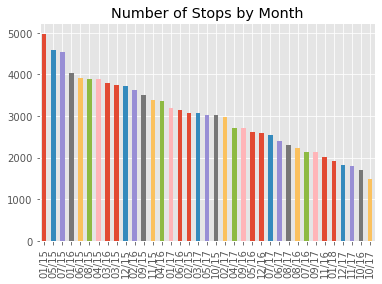

<Figure size 8000x4800 with 0 Axes>

In [36]:
df_concat['ACTIVITY_MONTH_YEAR'].value_counts().plot.bar(title="Number of Stops by Month")

from matplotlib.pyplot import figure
figure(num=None, figsize=(100, 60), dpi=80, facecolor='w', edgecolor='k')

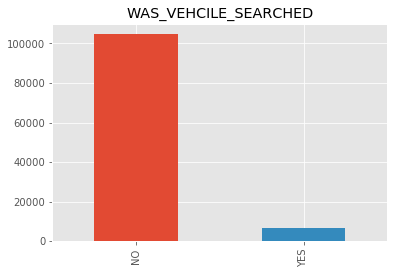

In [37]:
df2['WAS_VEHCILE_SEARCHED'].value_counts().plot.bar(title="WAS_VEHCILE_SEARCHED")

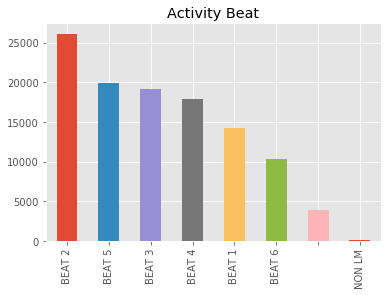

In [38]:
df_concat['ACTIVITY_BEAT'].value_counts().plot.bar(title="Activity Beat")

Text(0, 0.5, 'values')

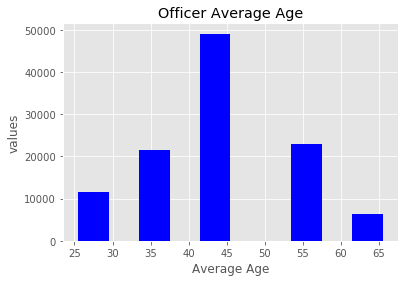

In [39]:
# Officer Mean Age histogram  
df_concat['OFFICER_AGE_MEAN'].hist(color = 'blue')

plt.title('Officer Average Age')
plt.xlabel('Average Age')
plt.ylabel('values')


Text(0, 0.5, 'values')

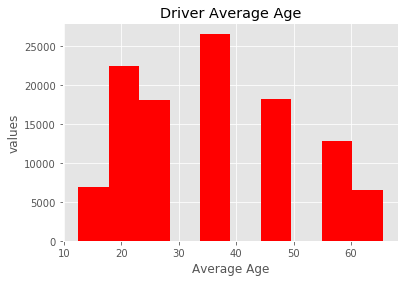

In [40]:
# Distribution of Age in the Dataset 
df_concat['DRIVER_AGE_MEAN'].hist(color='red')

plt.title('Driver Average Age')
plt.xlabel('Average Age')
plt.ylabel('values')


# Logistic Regression 

In [ ]:
# Importing sklearn package to run logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [ ]:
# define dependent and independent variables
X = X1

In [ ]:
# Train/Test spilt on our data having test size be 25% of the main data
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=2019)

In [ ]:
# Since the target variable is not 50/50 we are oversampling so that the target option (Churn, Yes or No) is even
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=2019)
X_train_resample, y_train_resample = ros.fit_resample(X_train, y_train)

In [ ]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(solver='liblinear')

# fit the model with data
logreg = logreg.fit(X_train_resample,y_train_resample)

#
y_pred=logreg.predict(X_test)

In [ ]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

In [ ]:

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
#Model Accuracy 
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1_Score:",f1_score(y_test, y_pred, average='weighted'))
#print("AUC:",roc_auc_score(y_test, y_pred)) *** This does not work

In [ ]:
#Recursive Feature Elimination 
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
for i in range(1, X1.shape[1]+1):
    print(i)
    # create a base classifier used to evaluate a subset of attributes
    model = LogisticRegression(solver='liblinear')
    # create the RFE model and select 3 attributes; Target Variable Y2
    rfe = RFE(model, i)
    rfe = rfe.fit(X1, y)
    # summarize the selection of the attributes
    print('Model with the best', i, 'features')
    print(dict(zip(X1.columns, rfe.ranking_)))

In [ ]:
# Import Decision Tree Classifier  
from sklearn.tree import DecisionTreeClassifier

# Create Decision Tree Classifier Object 
clf = DecisionTreeClassifier()
clf = clf.fit(X_train_resample, y_train_resample)

# Predict the response for test dataset 
y_pred = clf.predict(X_test)

# Model Accuracy 
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1_Score:",f1_score(y_test, y_pred, average='weighted'))
#print("AUC:",roc_auc_score(y_test, y_pred))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
kneigh = KNeighborsClassifier()
kneigh = kneigh.fit(X_train_resample, y_train_resample)
y_pred = kneigh.predict(X_test)

In [ ]:
# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1_Score:",f1_score(y_test, y_pred, average='weighted'))
#print("AUC:",roc_auc_score(y_test, y_pred))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ADA = AdaBoostClassifier(n_estimators=70, random_state=2019)
ADA = ADA.fit(X_train_resample, y_train_resample)
y_pred = ADA.predict(X_test)

In [ ]:
# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1_Score:",f1_score(y_test, y_pred, average='weighted'))
#print("AUC:",roc_auc_score(y_test, y_pred))

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=2019)
X_resample, y_resample = ros.fit_resample(X, y)

In [ ]:
#df_concat.to_csv('ImputedData', ',')